In [647]:
Ns=12 #only even numbers
N, PBC = 4, False
J, U,V = 1,40,0

In [648]:
from numpy import zeros, sqrt, linalg, array, ones, exp, eye, copy,sign,real,imag,transpose,log,average, var, conj, math, var,append, save
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time

def genBase(js_,N_,base_,baseQ1_):
    if N_==0:
        base_.append( [0]*Ns )
        for j in js_:
            base_[-1][j]+=1
        baseQ1_.append([x for x in js_])
    else:
        leftBound = 0
        if len(js_)>0:
            leftBound = js_[-1]
        for j in range(leftBound,Ns):
            genBase(js_+[j],N_-1,base_,baseQ1_)
        
base, baseQ1 = [], []
base1, base1Q1 = [],[]
base2, base2Q1= [],[]

genBase([],1,base1,base1Q1)
genBase([],2,base2,base2Q1)
genBase([],N,base,baseQ1)

NoS1, NoS2, NoS = len(base1), len(base2), len(base)

print('Number of base states =',NoS)

Number of base states = 1365


In [649]:
#################################################################
##Compute energy and the GS of H for choosen N ##################
#################################################################

def generateHamitlonian(base_, J_,U_,V_):
    NoS = len(base_)
    H = lil_matrix((NoS,NoS),dtype=float)
    for i in range(NoS):
        sL = base_[i]
        for j in range(0,Ns-1):
            if sL[j]>0:
                coef = -J_*sqrt(sL[j])*sqrt(sL[j+1]+1)
                sR = [x for x in sL]
                sR[j]-=1
                sR[j+1]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        if PBC:     
            if sL[Ns-1]>0:
                coef = -J_*sqrt(sL[Ns-1])*sqrt(sL[0]+1)
                sR = [x for x in sL]
                sR[Ns-1]-=1
                sR[0]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        coefU = 0.0
        for j in range(0,Ns):
            coefU += 0.5*U_*sL[j]*(sL[j]-1)
        H[i,i] += coefU
        coefV = 0.0
        for j in range(0,Ns-1):
            coefV += V_*sL[j]*sL[j+1]
        if PBC:  
            coefV += V_*sL[Ns-1]*sL[0]
        H[i,i] += coefV
    return H

print("Computing reference GS...",end='')
t0 = time.time()

H_1atom = generateHamitlonian(base1, J,U,V)
E, v = eigsh(H_1atom,k=1,which='SA')  
E_1atom = E[0]
GS_1atom = sign(v[0,0])*v[:,0]

H_2atom = generateHamitlonian(base2, J,U,V)
E, v = eigsh(H_2atom,k=1,which='SA')  
E_2atom = E[0]
GS_2atom = sign(v[0,0])*v[:,0]
#print(H_2atom)
H = generateHamitlonian(base, J,U,V)
E, v = eigsh(H,k=1,which='SA')  
E_R = E[0]
GS = sign(v[0,0])*v[:,0]

print(" DONE in ",(time.time()-t0)*1000,"[ms]")

Computing reference GS... DONE in  128.82328033447266 [ms]


In [650]:
def secondToFirst(state):
    baseState = state.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js

def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

def energy(c):
    return sum(real(conj(c)*H*c))

def getNis(c):
    out = zeros(Ns)
    for i in range(NoS):
        out += abs(c[i])**2*array(base[i])
    return out   

def getG2sX(c,x):
    G2s = zeros(Ns,dtype=complex)
    for i in range(NoS):
        fock = base[i]
        for xp in range(Ns):
            G2s[xp] += abs(c[i])**2*fock[x]*fock[xp]
            if x==xp:
                G2s[xp] -= abs(c[i])**2*fock[x]
    return G2s  

In [651]:
A1 = zeros([NoS,int((Ns+1)/2)],dtype=int)

for i in range(NoS):
    A1[i] = array(base[i][0:int((Ns+1)/2)])  + array(base[i][Ns:int((Ns-1)/2):-1])
        
#########################333####################################################################
combs = []
for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        
combsh = []
for n in range(Ns):
    for n2 in range(n, Ns):
        if n+n2 < Ns:
            combsh.append([n,n2])

def P(fockState):
    js = secondToFirst(fockState)
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph(fockState):
    js = secondToFirst(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out

A2 = zeros([NoS,len(combs)],dtype=int)
A2h = zeros([NoS,len(combsh)],dtype=int)


for i in range(NoS):
    A2[i] = P(base[i])
    A2h[i] = Ph(base[i])
    
def psi12to14(psi12):
    out = []
    num =0
    for comb in combs:
        if comb[0]+comb[1]< Ns:
            out.append(psi12[num])
        num+=1
    return array(out)

def psi14to12(psi14):
    out = zeros(len(combs))
    num =0
    for combh in combsh:
        ind1 = combh[0]
        ind2 = combh[1]
        out[combs.index([ind1,ind2])] = psi14[num]
        
        ind1 += Ns-1-(combh[0]+combh[1])
        ind2 += Ns-1-(combh[0]+combh[1])
        out[combs.index([ind1,ind2])] = psi14[num]
        num+=1      
    return out
     
##############################################################################################

Norms_2atom = []
for i in range(len(base2)):
    Norms_2atom.append( norm(base2[i]) )

Norms1 = []
for i in range(NoS):
    Norms1.append( norm(base[i]) )

def variance1h( psi ):
    c = normalised(real(array(Norms1)*exp(A1.dot(log(psi,dtype=complex)))))
    return sum((c-GS)**2)

def findPsi1(method='half'):
    print("Looking for Psi_A1...",end='')
    minimizer_kwargs = {"method": "COBYLA"}
    t0 = time.time()
    if method=='half':
        psi0h = GS_1atom[0:int((Ns+1)/2)]
        reth = basinhopping(variance1h, psi0h, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=10)
        psi = append(reth.x, reth.x[::-1])
    if method=='whole':
        psi0 = GS_1atom
        ret = basinhopping(variance1, psi0, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=5)
        psi = ret.x
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi

In [652]:
####################################################
## Functions for Ansatz 2 ##########################
####################################################

def normalised(arr):
    return arr / sqrt(sum(abs(arr)**2))

def variance2( psi ):
    c = real(array(Norms1)*exp(A2.dot(log(psi,dtype=complex))))
    return 1-(c.dot(GS)/sqrt(c.dot(c)))**2

def variance2h( psi ):
    c = real(array(Norms1)*exp(A2h.dot(log(psi,dtype=complex))))
    return 1-(c.dot(GS)/sqrt(c.dot(c)))**2

def findPsi2():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
    psi0 = GS_2atom
    ret = minimize(variance2, psi0, method='Powell', tol=1e-12, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return ret.x

def findPsi2h():
    print("Looking for Psi_A2...",end='')
    t0 = time.time()
    psi0 = psi12to14(GS_2atom)
    ret = minimize(variance2h, psi0, method='Powell', tol=1e-12, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi14to12(ret.x)

def reshapePhiTo2D(phi1D):
    out = zeros([Ns,Ns],dtype=complex)
    num=0
    for n in range(Ns):
        out[n][n] = phi1D[num]
        num+=1
        for n2 in range(n+1, Ns):
            out[n][n2] = phi1D[num]
            out[n2][n] = phi1D[num]
            num+=1
    return out

def psi(_xs, _phiA2):
    out = 1
    for i in range(0,len(_xs)):
        for j in range(i+1,len(_xs)):
            out *= _phiA2[_xs[i],_xs[j]]
    return out

def calcG1(_phi):
    out = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            elem = 0
            for x2 in range(0,Ns):
                for x3 in range(0,Ns):
                    for x4 in range(0,Ns):
                        elem+= psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
            out[x,xp]=elem
    return out

def calcG2(_phi):
    out = zeros([Ns,Ns],dtype=float)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            elem = 0
            for x3 in range(0,Ns):
                for x4 in range(0,Ns):
                    elem+= abs(psi([x,xp,x3,x4],_phi))**2
            out[x,xp]=elem
    return out

In [653]:
####################################################
## Compute best Ansatz functions ###################
####################################################
phiA21D = findPsi2h()

phiA2 = reshapePhiTo2D(phiA21D)
G1R = calcG1(phiA2)
G2R = calcG2(phiA2)

Looking for Psi_A2... DONE in 6934.834003448486 [ms]


(E_GS-E_free)/(|N E_free|) =  0.174959198767348
(E_A2-E_free)/(|N E_free|) =  0.17496990420124262
|<ED|A2>|^2 =  0.9999976247883153


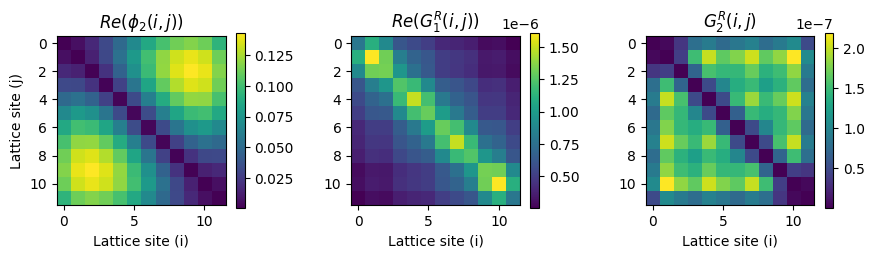

In [654]:
####################################################
## Plot Ansatz functions ###########################
####################################################

import numpy as np

phiA21D /= sqrt(sum(sum(abs(phiA2)**2)))
phiA2 /= sqrt(sum(sum(abs(phiA2)**2)))

c2 = normalised( real(array(Norms1)*exp(A2.dot(log(phiA21D,dtype=complex)))) )

EAnsatz2 = energy(c2)

print('(E_GS-E_free)/(|N E_free|) = ', (E_R-N*E_1atom)/(abs(N*E_1atom)) )
print('(E_A2-E_free)/(|N E_free|) = ',  (EAnsatz2-N*E_1atom)/(abs(N*E_1atom)) )
print('|<ED|A2>|^2 = ',(abs(c2.dot(GS))**2))

fig, ax = plt.subplots(1,3,figsize=(9,2.5))
cmap = ax[0].imshow(real(phiA2))
cbar = plt.colorbar(cmap)
cmap = ax[1].imshow(real(G1R))
cbar = plt.colorbar(cmap)
cmap = ax[2].imshow(G2R)
cbar = plt.colorbar(cmap)

ax[0].set_xlabel('Lattice site (i)')
ax[1].set_xlabel('Lattice site (i)')
ax[2].set_xlabel('Lattice site (i)')
ax[0].set_ylabel('Lattice site (j)')

ax[0].set_title('$Re(\phi_2(i,j))$')
ax[1].set_title('$Re(G_1^R(i,j))$')
ax[2].set_title('$G_2^R(i,j)$')
plt.tight_layout()
plt.show()

In [655]:
c2 = normalised( real(array(Norms1)*exp(A2.dot(log(phiA21D,dtype=complex)))) )

Econst = energy(c2)

for i in range(len(phiA21D)):
    tmpPhiA21D = phiA21D.copy()
    tmpPhiA21D[i]+=1e-6
    c2 = normalised( real(array(Norms1)*exp(A2.dot(log(tmpPhiA21D,dtype=complex)))) )
    #print(i,(energy(c2)-Econst)/1e-6/Econst)

In [656]:
import random

def transform1Dto2D(func1D):
    out = np.zeros([Ns,Ns])
    it = 0
    for x in range(0,Ns):
        for xp in range(x,Ns):
            out[x,xp] = func1D[it]
            out[xp,x] = func1D[it]
            it+=1
    return out
#print(0.1*np.random.rand(10))
phi = transform1Dto2D(phiA21D+0.0001*np.random.rand(len(phiA21D)))
#phi = transform1Dto2D(phiA21D)
phiR = transform1Dto2D(phiA21D)
#phi /= np.sqrt(sum(sum(abs(phi)**2)))

In [765]:
from numpy import zeros, sqrt, linalg, loadtxt,array, ones, exp, eye, copy,sign,real,imag,transpose,log,average,sort, var, conj, math, var,append, save,argsort, delete
from numpy.linalg import inv
import matplotlib.pyplot as plt
from random import randint, random, gauss
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time
import numpy as np

#here we try to estimate 5 atomic function based on 4 atomic correlator. We load data for 4 atoms, compute G4 and F4

# basis = []
# basisXXp = []
# G4 = []
# F4 = []



def getG4(xs,basis_,G4_):
    xs_ = np.copy(xs)
    xs_ = sort(xs_)

    index = basis_.index(Ns**3*xs_[0]+Ns**2*xs_[1]+Ns*xs_[2]+xs_[3])
    return G4_[index]

def getF4(xs,basis_,F4_):
   # print(array(sort(xs)))
    xs_ = np.copy(xs)
    xs_ = sort(xs_)

    index = basis_.index(Ns**3*xs_[0]+Ns**2*xs_[1]+Ns*xs_[2]+xs_[3])
    return F4_[index]

def computeG4(xs):
    out = 0
    tmp = 1.0
    for i in range(0,N):
        for j in range(i+1,N):
            tmp *= abs(phi[xs[i],xs[j]])**2
    return out

def psi4(xs):
    out = 1
    for i in range(0,len(xs)):
        for j in range(i+1,len(xs)):
            out *= phi[xs[i],xs[j]]
    return out
            

def computeF4(xs):
    out = 0.0
    for x4 in range(0,Ns):
            out += psi4([xs[0],xs[2],xs[3],x4])*psi5([xs[1],xs[2],xs[3],x4])
    return out



def delta(x):
    if x==0:
        return 1
    return 0

def F(_phi,x,xp,x2,x3,x4):
    return np.conj(psi([x,x2,x3,x4],_phi))*psi([xp,x2,x3,x4],_phi)

def calcCorrectionToG1(_phi,_dphi):
    h = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            h[x,xp] = _dphi[x,xp]/_phi[x,xp]
            
    dG1 = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            for x2 in range(0,Ns):
                for x3 in range(0,Ns):
                    for x4 in range(0,Ns):
                        dG1[x,xp] += (N-1)*(h[x,x2]+h[xp,x2])*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        dG1[x,xp] += 2*(N-2)*(N-1)/2*h[x2,x3]*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)   
    return dG1

def calcCorrectionToG1v2(_phi,_dphi):
    h = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            h[x,xp] = _dphi[x,xp]/_phi[x,xp]
            
    dG1 = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            for x2 in range(0,Ns):
                for x3 in range(0,Ns):
                    for x4 in range(0,Ns):
                        dG1[x,xp] += (h[x,x2]+h[xp,x2])*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        dG1[x,xp] += (h[x,x3]+h[xp,x3])*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        dG1[x,xp] += (h[x,x4]+h[xp,x4])*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        dG1[x,xp] += 2*h[x2,x3]*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)   
                        dG1[x,xp] += 2*h[x2,x4]*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)   
                        dG1[x,xp] += 2*h[x3,x4]*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)   
    return dG1

def calcCorrectionToG1v3(_phi,_dphi):
    h = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            h[x,xp] = _dphi[x,xp]/_phi[x,xp]
    print("X2")
    dG1 = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            for x2 in range(0,Ns):
                for x3 in range(0,Ns):
                    for x4 in range(0,Ns):
                        dG1[x,xp] += 3*(h[x,x2]+h[xp,x2])*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        #dG1[x,xp] += (h[x,x3]+h[xp,x3])*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        #dG1[x,xp] += (h[x,x4]+h[xp,x4])*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        dG1[x,xp] += 3*2*h[x2,x3]*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)   
                       # dG1[x,xp] += 2*h[x2,x4]*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)   
                       # dG1[x,xp] += 2*h[x3,x4]*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)   
    return dG1

In [766]:
# def calcCorrectionToEK1(_phi,_dphi):
#     h = zeros([Ns,Ns],dtype=complex)
#     for x in range(0,Ns):
#         for xp in range(0,Ns):
#             h[x,xp] = _dphi[x,xp]/_phi[x,xp]
            
#     out = 0
#     for x in range(0,Ns):
#         for xp in range(0,Ns):
#             for x2 in range(0,Ns):
#                 for x3 in range(0,Ns):
#                     for x4 in range(0,Ns):
#                         out += (N-1)*delta(x+1-x2)*h[x,xp]*psi([x,xp,x3,x4],_phi)*psi([x2,xp,x3,x4],_phi)
#                         out += (N-1)*delta(x2+1-xp)*h[x,xp]*psi([x2,x,x3,x4],_phi)*psi([xp,x,x3,x4],_phi)
#                         out += 2*(N-2)*(N-1)*delta(x2+1-x3)*h[x,xp]*psi([x2,x,xp,x4],_phi)*psi([x3,x,xp,x4],_phi) 
#     return -2*out

def calcCorrectionToG2(_phi,_dphi):
    h = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            h[x,xp] = _dphi[x,xp]/_phi[x,xp]
            
    dG2 = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            for x3 in range(0,Ns):
                for x4 in range(0,Ns):
                        dG2[x,xp] += 2*(h[x,xp]+(N-2)*h[x,x3]+(N-2)*h[xp,x3]+(N-2)*(N-3)*h[x3,x4])*abs(psi([x,xp,x3,x4],_phi))**2
    return dG2

def calcCorrectionToEK(_phi,_dphi):
    h = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            h[x,xp] = _dphi[x,xp]/_phi[x,xp]
            
    WK = zeros([Ns,Ns],dtype=complex)
    for x in range(0,Ns):
        for xp in range(0,Ns):
            for x2 in range(0,Ns):
                for x3 in range(0,Ns):
                    for x4 in range(0,Ns):
                        #WK[x,xp] += (N-1)*h[x,xp]*(delta(x+1,x2)+delta(xp,x2+1)+2*(N-2)*delta(x2+1,x3))*psi([x,x2,x3,x4],_phi)*psi([xp,x2,x3,x4],_phi)
                        WK[x,xp] += (N-1)*delta(x+1-x2)*psi([x,xp,x3,x4],_phi)*psi([x2,xp,x3,x4],_phi)
                        WK[x,xp] += (N-1)*delta(x2+1-xp)*psi([x2,x,x3,x4],_phi)*psi([xp,x,x3,x4],_phi)
                        WK[x,xp] += (N-1)*2*(N-2)*delta(x2+1-x3)*psi([x2,x,xp,x4],_phi)*psi([x3,x,xp,x4],_phi)
            WK[x,xp] /= _phi[x,xp]
    out = 0
    for x in range(0,Ns):
        for xp in range(0,Ns):
           # out += -2*WK[x,xp]*h[x,xp]
            out += -2*WK[x,xp]*_dphi[x,xp]
           # out += -2*WK[x,xp]
  #  print("AAA")
    return real(out)

def calcdEK(_dG1):
    out = 0
    for x in range(0,Ns-1):
        out -= 2*real(_dG1[x,x+1])
    return out

In [767]:
for i in range(10000):
    dphiA2 = (np.random.rand(Ns,Ns)-0.5*np.ones([Ns,Ns]))
    dphiA2 += transpose(dphiA2)
    dphiA2 /= sqrt(sum(sum(abs(dphiA2)**2)))
    phiA2 /= sqrt(sum(sum(abs(phiA2)**2)))

    A = -2*sum(sum(phiA2*dphiA2))
    if abs(A)<0.001:
        break

#print(phiA2.shape)
#A = -2*sum(sum(phiA2.dot(dphiA2)))
dphiA2 = A*dphiA2
print("A=",A)
print(sqrt(sum(sum(abs(phiA2)**2))))
print(sqrt(sum(sum(abs(phiA2+dphiA2)**2))))
#print(phiA2)

A= (-0.00031418376443787324+0j)
1.0
1.0


In [770]:
dG1R = calcG1(phiA2+dphiA2) - calcG1(phiA2)
dG1 = calcCorrectionToG1(phiA2,dphiA2)
#dG1v2 = calcCorrectionToG1v2(phiA2,dphiA2)
#dG1v3 = calcCorrectionToG1v3(phiA2,dphiA2)
#dG1R /= sqrt(sum(sum(abs(dG1R)**2)))
#dG1 /= sqrt(sum(sum(abs(dG1)**2)))
#dG1v2 /= sqrt(sum(sum(abs(dG1v2)**2)))
#print(sum(sum(abs(dG1v2-dG1v3)**2)),sum(sum(abs(dG1v2)**2)),sum(sum(abs(dG1v2-dG1)**2))/sum(sum(abs(dG1v2)**2)))
#print(sum(sum(abs(dG1v2-dG1v3)**2)),sum(sum(abs(dG1v2)**2)),sum(sum(abs(dG1v2-dG1v3)**2))/sum(sum(abs(dG1v2)**2)))
#dEKR = calcdEK(dG1R)
#dEKdG1 = calcdEK(dG1)
#dEK = calcCorrectionToEK(phiA2,dphiA2)
#dEK3 = calcCorrectionToEK1(phiA2,dphiA2)
#print(r'dE_K^R=',dEKR,r'dE_K(1)=',dEKdG1,r'dE_K=',dEK)

dG2R = calcG2(phiA2+dphiA2) - calcG2(phiA2)
dG2 = calcCorrectionToG2(phiA2,dphiA2)
#dG1 *=dG1R[1,1]/dG1[1,1]

In [769]:
print(dG1R[1,1],dG1[1,1])
print(dG2R[1,1],dG2[1,1])

(8.564320957444944e-15+0j) (8.506398542372015e-15+0j)
2.3770966741350784e-16 (2.3258074553885825e-16+0j)


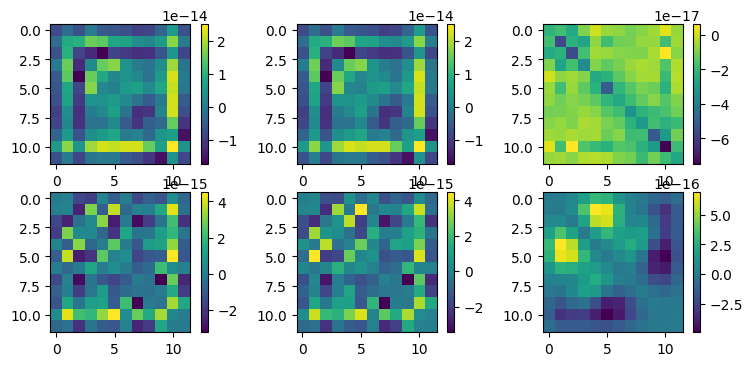

In [771]:
fig, ax = plt.subplots(2,3,figsize=[9,4])
cmap=ax[0,0].imshow(real(dG1R))
cbar = plt.colorbar(cmap)
cmap=ax[0,1].imshow(real(dG1v2))
cbar = plt.colorbar(cmap)
cmap=ax[0,2].imshow(real(dG1v2-dG1R))
cbar = plt.colorbar(cmap)

cmap=ax[1,0].imshow(real(dG2R))
cbar = plt.colorbar(cmap)
cmap=ax[1,1].imshow(real(dG2))
cbar = plt.colorbar(cmap)
cmap=ax[1,2].imshow(real(dG2-dG2R))
cbar = plt.colorbar(cmap)

plt.show()

In [60]:
    
def optiStep():
    basis = []
    basisXXp = []
    G4 = []
    F4 = []
    
    for x1 in range(0,Ns):
        for x2 in range(x1,Ns):
            basisXXp.append([x1,x2])
            for x3 in range(x2,Ns):
                for x4 in range(x3,Ns):
                    basis.append(Ns**3*x1+Ns**2*x2+Ns*x3+x4)
                    G4.append(computeG4([x1,x2,x3,x4]))
                    F4.append(computeF4([x1,x2,x3,x4]))
    
    WK = []
    WU = []
    WV = []
    for [x,xp] in basisXXp:
    # for x in range(0,Ns):
    #     for xp in range(0,Ns):
        elemWK = 0
        elemWU = 0
        elemWV = 0
        for x3 in range(0,Ns):
            for x4 in range(0,Ns):
               # elemWK += (N-1)*(2*(N-2)*(delta(x2+1,x3)+delta(x2,x3+1)+delta(x2-1,x3)+delta(x2,x3-1) ))*computeF4([x,xp,x3,x4])
            #    elemWK += (N-1)*( delta(x+1,x3)+delta(x-1,x3)+delta(xp+1,x3)+delta(xp-1,x3)  +2*(N-2)*(delta(x3+1,x4)+delta(x3,x4+1)))*computeF4([x,xp,x3,x4])
                elemWK += (N-1)*( delta(x+1,x3)+delta(x-1,x3)+delta(xp+1,x3)+delta(xp-1,x3)  +2*(N-2)*(delta(x3+1,x4)))*computeF4([x,xp,x3,x4])
              #  elemWK += (N-1)*(2*(N-2)*(delta(x2+1,x3))*computeF4([x,xp,x3,x4])
               # elemWK += (N-1)*(delta(x+1,x2)+delta(x-1,x2)+delta(xp-1,x2)+delta(xp+1,x2)+delta(x+1,x3)+delta(x-1,x3)+delta(xp-1,x3)+delta(xp+1,x3)+2*(N-2)*(delta(x2+1,x3)+delta(x2-1,x3)))*getF4([x,xp,x3,x4],basis,F4)
                elemWU += (delta(x,xp)+(N-2)*(delta(x,x3)+delta(xp,x3)+(N-3)*delta(x3,x4)))*computeG4([x,xp,x3,x4])
                elemWV += (delta(x+1,xp)+(N-2)*(delta(x+1,x3)+delta(xp,x3+1)+(N-3)*delta(x3+1,x4)))*getG4([x,xp,x3,x4],basis,G4)
        WK.append(-2*elemWK)
        WU.append(U*elemWU)
        WV.append(2*V*elemWV)
    W = array(WK)+array(WU)+array(WV)
   # print(np.shape(phiA21D))
    W = array([W[i]/phiA21D[i] for i in range(len(W))])
    W /= sqrt(sum(abs(W)**2))
    return sqrt(abs(W))
    
def transform1Dto2D(func1D):
    out = np.zeros([Ns,Ns])
    it = 0
    for x in range(0,Ns):
        for xp in range(x,Ns):
            out[x,xp] = func1D[it]
            out[xp,x] = func1D[it]
            it+=1
    return out

-7.675943788915963 -7.647948370812628


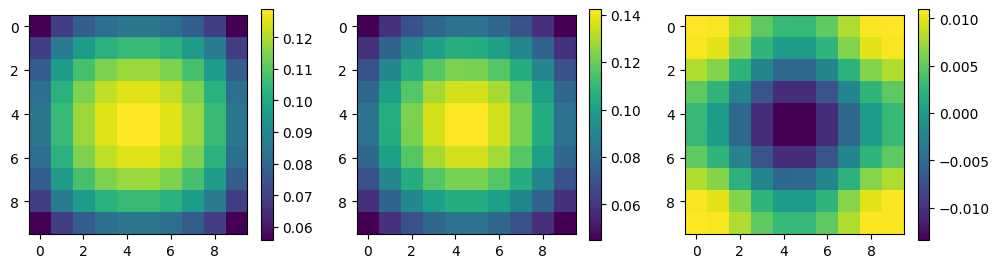

In [382]:
# W = array(WK)+array(WU)+array(WV)
# W /= sqrt(sum(abs(W)**2))
#print(len(basisXXp))

phi /= sqrt(sum(sum(abs(phi)**2)))
W = optiStep()


cW = normalised( real(array(Norms1)*exp(A2.dot(log(W,dtype=complex)))) )
c2 = normalised( real(array(Norms1)*exp(A2.dot(log(phiA21D,dtype=complex)))) )
W = transform1Dto2D(W)
W /= sqrt(sum(sum(abs(W)**2)))
print(energy(c2),energy(cW))
#plt.plot(W)
fig, ax = plt.subplots(1,3,figsize=[12,3])

cmap=ax[0].imshow(phi)
cbar = plt.colorbar(cmap)
cmap=ax[1].imshow(abs(W))
cbar = plt.colorbar(cmap)
#ax[1].imshow(-W.reshape(Ns,Ns))
cmap=ax[2].imshow(abs(phi)-abs(W))
cbar = plt.colorbar(cmap)

7.195942732623514e-11
7.195942732623514e-11
